# **Multi-fidelity reduced-order modeling on Burger's equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions over time and parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines dimensionality reduction via Proper Orthogonal Decompostion (POD) with multi-fidelity long-short term memory neural (LSTM) network surrogates.


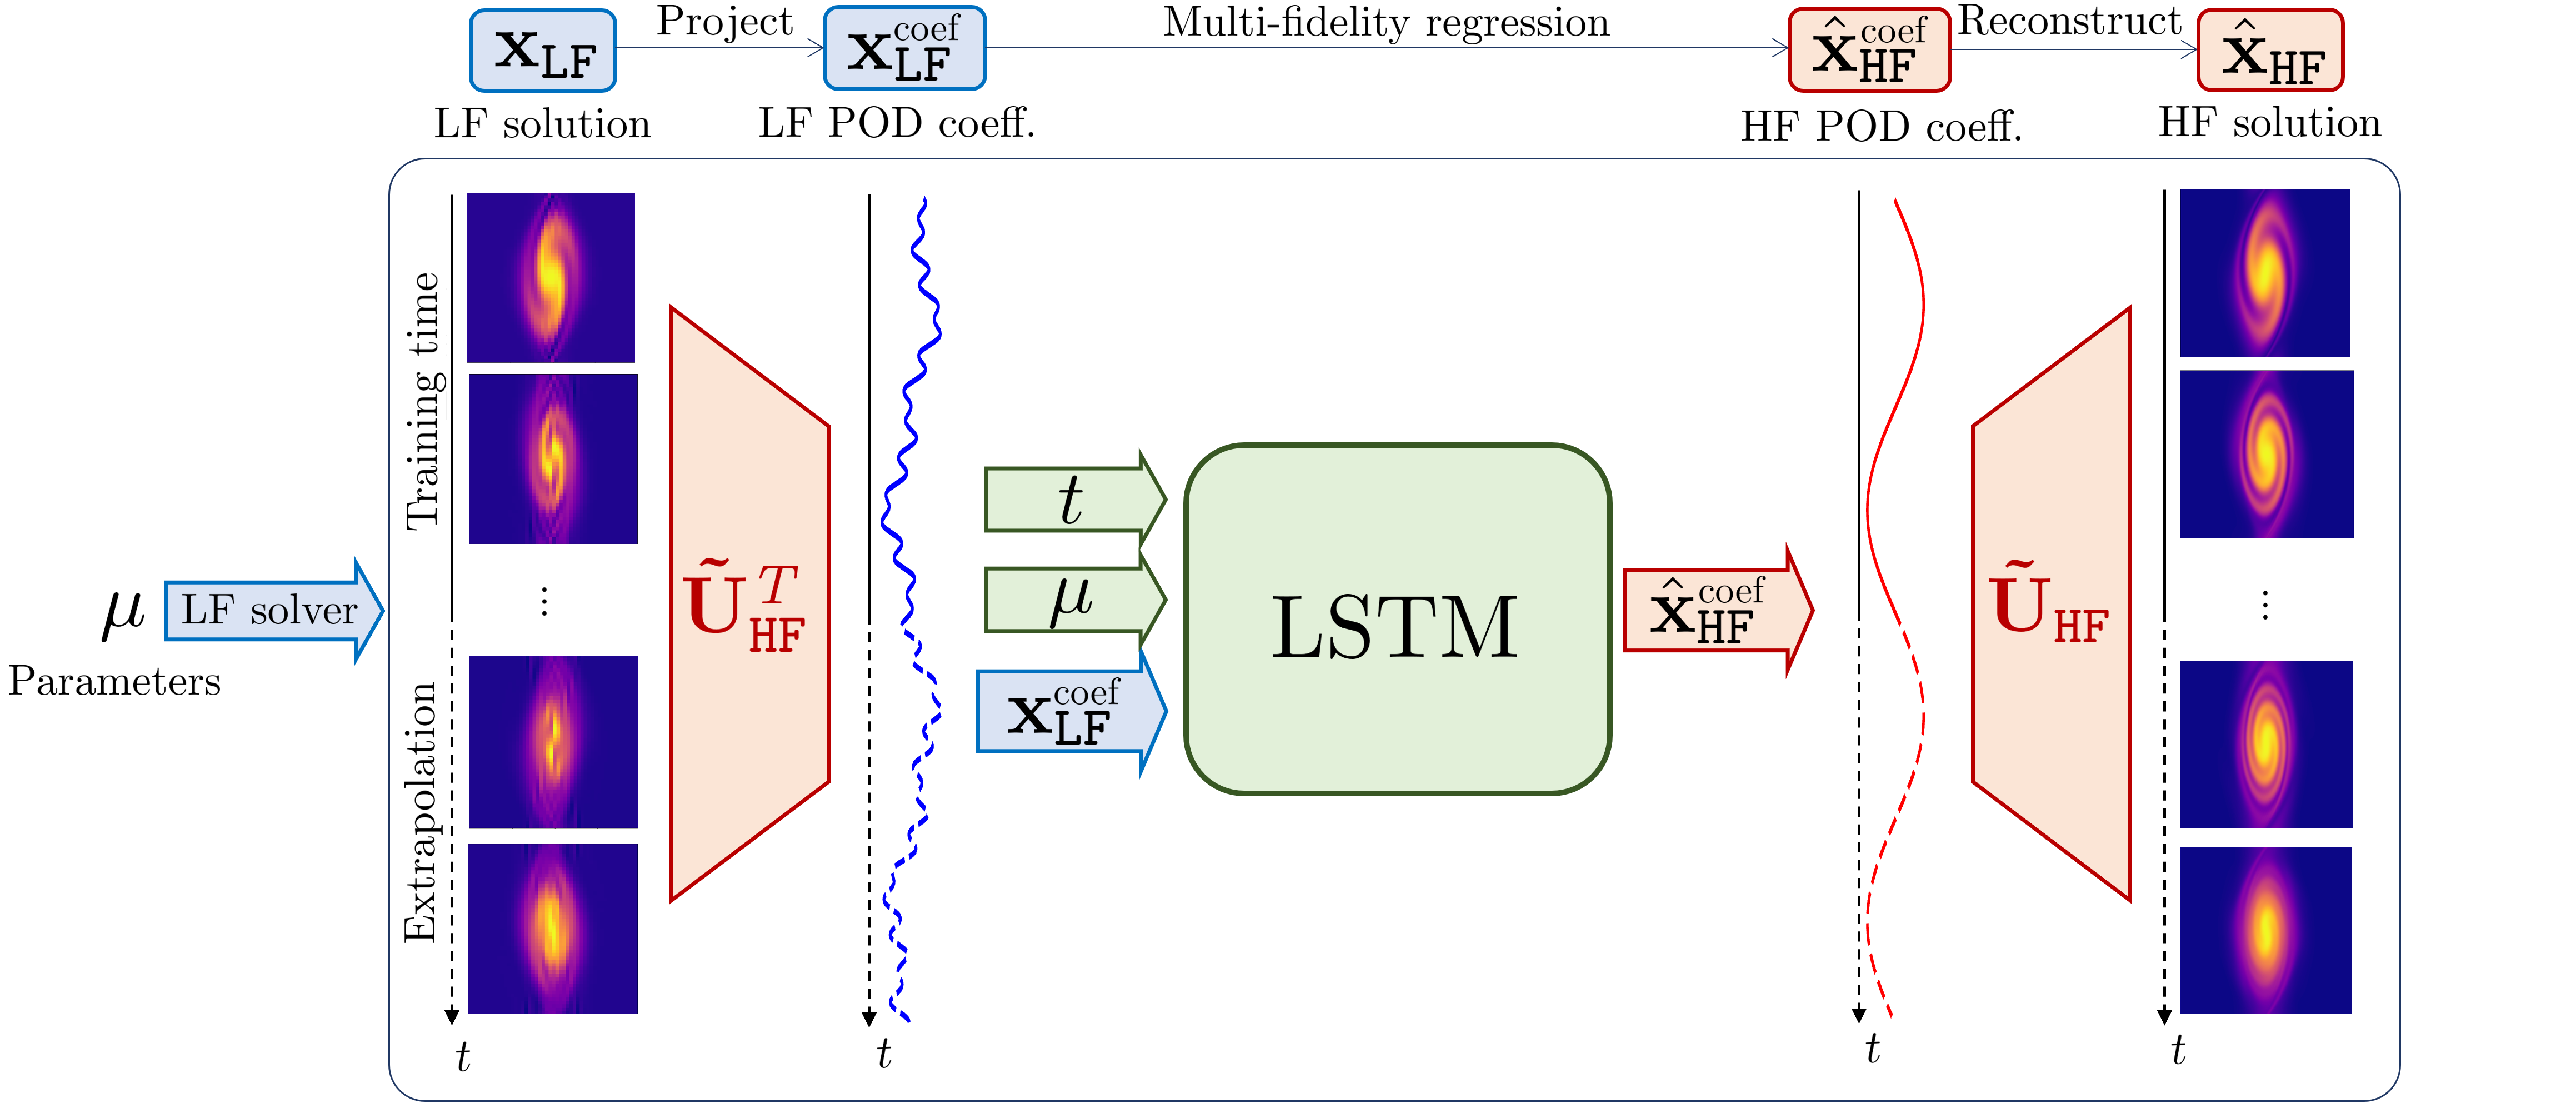

#### In order to do so, we consider the following training strategy

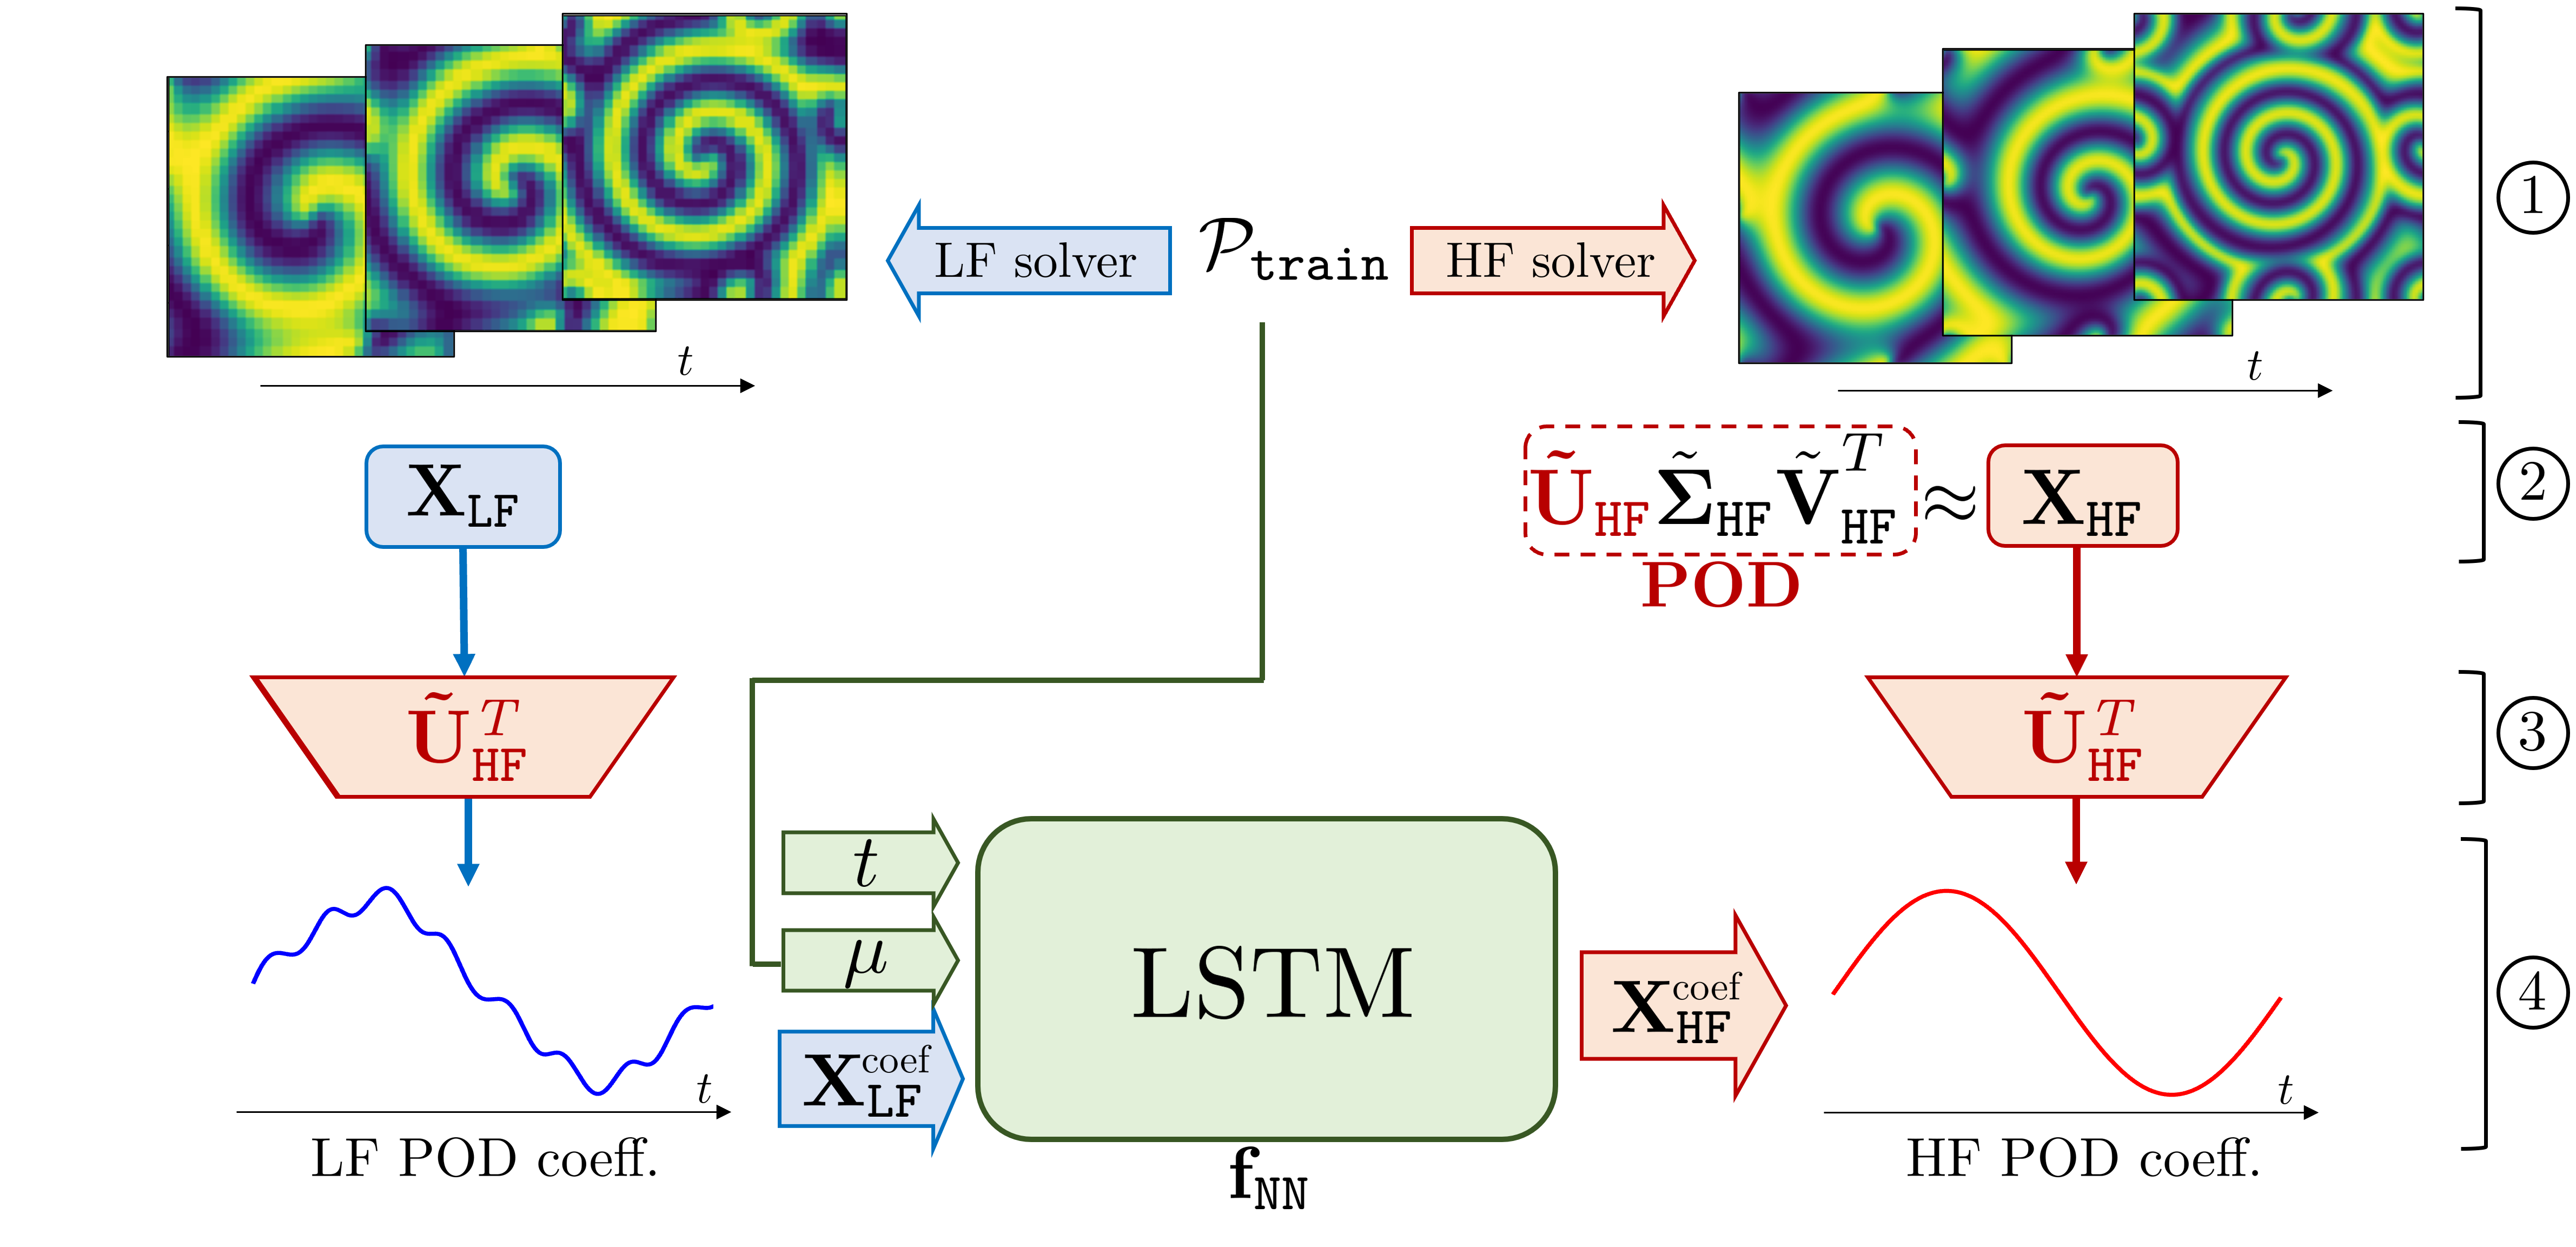

#### (1) **Generation of multi-fidelity dataset**
#### (2) **Dimensionality reduction via POD**
#### (3) **Computing reduced-coordinates via projection**
#### (4) **Training LSTM neural network surrogate model**



#### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = False
save = False

#### Problem setup
We consider the following parameter dependent Burger's equation
</br></br>
$$
\begin{equation}
\tag{1}
\frac{\partial u}{\partial t} + \frac{\partial }{\partial x}\left(\frac{1}{2}u^{2}\right) = \frac{1}{Re}\frac{\partial^{2} u}{\partial x^{2}}
\end{equation}
$$
</br>
in $\Omega=(0,1)$, with homogenous Dirichlet boundary conditions and with the following initial condition
</br></br>
$$u(x,0)=\frac{x}{1+e^{-\frac{1}{16}Re\left(1-4x^{2}\right)}},\quad\quad x\in\Omega.$$
</br>
$Re$ denotes the Reynolds parameter and we consider $Re \in [80, 500]$.
</br></br>
[Credits to Nicola Rares Franco]



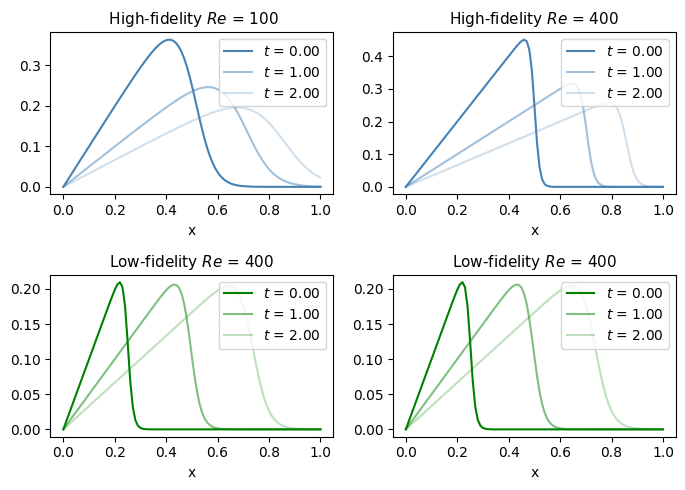

In [ ]:
# High-fidelity model: exact analytical solution
def u_HF(x, t, re):
  A0 = np.exp(re/8.0)
  return x/(t+1)/(1.0+np.exp(re*(x**2)/(4*t+4))*((t+1)/A0)**0.5)

# Low-fidelity model
def u_LF(x, t, re):
  A0 = np.exp(re/8.0)
  return x/(t+1)/(1.0+np.exp(re*(x)/(4*t+4))*((t+1)/A0)**0.5)

# Space-time discretization
nh, nt = 101, 151
T = 2.
L = 1.
x = np.linspace(0, L, nh) # spatial grid
t = np.linspace(0, T, nt) # timepoints

# Uniform sampling of 20 different reynolds numbers
nre = 20
re_min, re_max = 80, 500
re = np.linspace(0, 1, nre) # we sample in [0,1] in order to work with normalized data

#split in train/test with 20% data for testing
re_train, re_test = train_test_split(re, test_size=0.2, random_state=seed)
nre_train, nre_test = len(re_train), len(re_test)

normalize = lambda r: (r-re_min)/(re_max-re_min) # maps [80, 500] onto [0, 1]
denormalize = lambda r: r*(re_max-re_min) + re_min # maps [0, 1] onto [80, 500]

# Let's see some ground truth simulations
times = [0, nt//2, nt-1]
alphas = [1.0, 0.5, 0.25]
plt.figure(figsize = (7, 5))
for j in range(3):
  plt.subplot(2,2,1)
  plt.plot(x, u_HF(x, t[times[j]], re = 100), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'steelblue')
  plt.title(" High-fidelity $Re$ = 100", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,2)
  plt.plot(x, u_HF(x, t[times[j]], re = 400), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'steelblue')
  plt.title("High-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,3)
  plt.plot(x, u_LF(x, t[times[j]], re = 400), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'green')
  plt.title("Low-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,4)
  plt.plot(x, u_LF(x, t[times[j]], re = 400), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'green')
  plt.title("Low-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
plt.tight_layout()

#### (1) Generation of multi-fidelity dataset

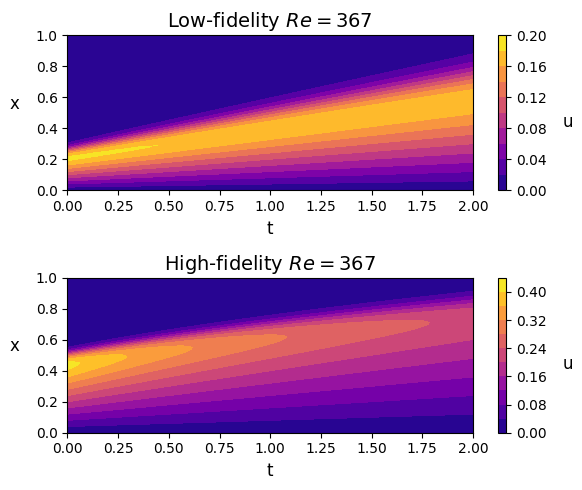

In [ ]:
#Generate training data
u_hf = np.zeros((nre, nt, nh))
u_lf = np.zeros((nre, nt, nh))

for p in range(nre_train):
    for n in range(nt):
        for i in range(nh):
            u_hf[p, n, i] = u_HF(x[i], t[n], denormalize(re[p]))
            u_lf[p, n, i] = u_LF(x[i], t[n], denormalize(re[p]))


#Generate test data
u_hf_test = np.zeros((nre_test, nt, nh))
u_lf_test = np.zeros((nre_test, nt, nh))

for p in range(nre_test):
    for n in range(nt):
        for i in range(nh):
            u_hf_test[p, n, i] = u_HF(x[i], t[n], denormalize(re_test[p]))
            u_lf_test[p, n, i] = u_LF(x[i], t[n], denormalize(re_test[p]))

# Plot the data
ind_re = 5 # Re = 367
t_grid, x_grid = np.meshgrid(t, x)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
surf = ax.contourf(t_grid, x_grid, u_lf[ind_re].T, cmap='plasma', levels=10)
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
cbar = fig.colorbar(surf, ax=ax)
cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
plt.title('Low-fidelity $Re = $' + str(int(denormalize(re_train[ind_re]))), fontsize=14)
ax = fig.add_subplot(212)
surf = ax.contourf(t_grid, x_grid, u_hf[ind_re].T, cmap='plasma', levels=10)
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
cbar = fig.colorbar(surf, ax=ax)
cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
plt.title('High-fidelity $Re = $' + str(int(denormalize(re_train[ind_re]))), fontsize=14)
plt.tight_layout()
plt.show()

#### (2) Dimensionality reduction via POD

In [ ]:
def compute_randomized_SVD(S, N_POD, N_h, n_channels):
    U = np.zeros((n_channels * N_h, N_POD))
    for i in range(n_channels):
        U[i * N_h: (i + 1) * N_h], Sigma, Vh = extmath.randomized_svd(S[i * N_h: (i + 1) * N_h, :],
                                                                      n_components=N_POD, transpose=False,
                                                                      flip_sign=False, random_state=123)
    return U, Sigma

In [ ]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################
n_POD = 16 # we consider the first 16 basis functions

#Reshape for POD
u_hf_pod = np.reshape(u_hf, (nre*nt,nh))

#POD on HF training data
basis, S = compute_randomized_SVD(u_hf_pod, n_POD, nh, 1)

#### (3) Computing reduced-coordinates via projection

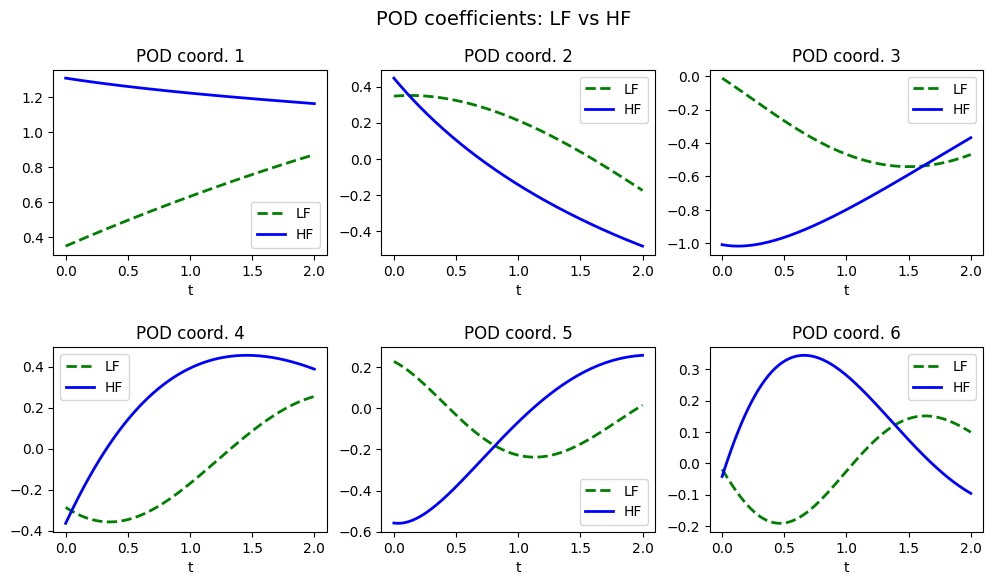

In [ ]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_lf_pod = np.reshape(u_lf, (nre*nt,nh))
u_lf_pod_test = np.reshape(u_lf_test, (nre_test*nt,nh))
u_hf_pod_test = np.reshape(u_hf_test, (nre_test*nt,nh))

ulf_train = u_lf_pod @ basis
uhf_train = u_hf_pod @ basis
ulf_test = u_lf_pod_test @ basis
uhf_test = u_hf_pod_test @ basis

#Reshape to make data suitable to LSTM network
ulf_train = np.reshape(ulf_train, (nre, nt, n_POD))
uhf_train = np.reshape(uhf_train, (nre, nt, n_POD))
ulf_test = np.reshape(ulf_test, (nre_test, nt, n_POD))
uhf_test = np.reshape(uhf_test, (nre_test, nt, n_POD))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('POD coefficients: LF vs HF', fontsize=14)
for mode in range(6):
    ax = fig.add_subplot(231 + mode)
    plt.plot(t, ulf_train[ind_re,:,mode], label = 'LF', linewidth = 2, color = 'green', linestyle = '--')
    plt.plot(t, uhf_train[ind_re, :, mode], label = 'HF', linewidth = 2, color = 'blue')
    ax.title.set_text('POD coord. ' + str(mode+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

#### (4) Training LSTM neural network surrogate model

In [ ]:
def create_model(params, dim_input, dim_output):
    #Define input
    inputs =  Input(shape=(None, dim_input))
    a = inputs

    #Define LSTM network
    for i in range(params['lay']):
        a = Dropout(params['dropout'])(a)
        a = LSTM(params['nodes'], return_sequences = True)(a)

    #Define output
    outputs = Dense(dim_output,activation='linear')(a)

    #Define model
    model = Model(inputs = inputs, outputs = outputs)

    #Define the optimizer and compile
    opti = getOpti(params['opti'],params['lr'])
    model.compile(loss = 'mse', optimizer = opti, metrics = ['mse'])
    return model

def getOpti(name,lr):
  if name == 'Adam':
      return Adam(learning_rate=lr,amsgrad=True)
  elif name == 'Nadam':
      return Nadam(learning_rate=lr)
  elif name == 'Adamax':
      return Adamax(learning_rate=lr)
  elif name == 'RMSprop':
      return RMSprop(learning_rate=lr)
  elif name == 'standardadam':
      return 'adam'

def sliding_windows(data_input, data_output, seq_length, freq=1):
  x = []
  y = []

  for i in range(data_input.shape[0]):
      for j in range(0, data_input.shape[1] - seq_length, freq):
          _x = data_input[i, j:(j + seq_length), :]
          _y = data_output[i, j:(j + seq_length), :]
          x.append(_x)
          y.append(_y)

  return np.array(x), np.array(y)

In [ ]:
# Reshape to make data suitable to LSTM network

# Train
t_grid_lstm, re_grid_lstm = np.meshgrid(t, re)
input_train = np.concatenate((t_grid_lstm[:,:,np.newaxis], re_grid_lstm[:,:,np.newaxis], ulf_train), axis = 2)
output_train = uhf_train

#Test
t_grid_lstm_test, re_grid_lstm_test = np.meshgrid(t, re_test)
input_test = np.concatenate((t_grid_lstm_test[:,:,np.newaxis], re_grid_lstm_test[:,:,np.newaxis], ulf_test), axis = 2)
output_test = uhf_test

#########################   LSTM NN HYPERPARAMETERS    ##########################
params_NN = { 'lay': 1,
             'nodes': 64,
             'lr':  1e-3,
             'opti': 'Adamax',
             'sequence_freq': 2,
             'sequence_length': 10,
             'epochs':  500,
             'patience' : 50,
             'dropout' : 0.1}

############################   TRAINING/LOADING    ##############################

if train:
    #Split the data into subsequences
    sequence_length = int(params_NN['sequence_length'])
    sequence_freq = int(params_NN['sequence_freq'])
    input_train_seq, output_train_seq = sliding_windows(input_train, output_train, sequence_length, sequence_freq)

    #Create the LSTM NN model
    model = create_model(params_NN, dim_input = n_POD + 2, dim_output = n_POD) #dim_input = param + time + POD modes ==  1 + 1 + n_POD

    #Train the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=params_NN['patience'], restore_best_weights=True)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism() # for reproducibility
    hist = model.fit(input_train_seq, output_train_seq, epochs=params_NN['epochs'], verbose = 1, callbacks=[callback])

else:
    name = './models/MF_POD_model'
    model = tf.keras.models.load_model(name)
if save:
    name = './models/MF_POD_model_new'
    model.save(name)

Epoch 1/500
45/45 [==============================] - 3s 6ms/step - loss: 0.0654 - mse: 0.0654
Epoch 2/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0306 - mse: 0.0306
Epoch 3/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0210 - mse: 0.0210
Epoch 4/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0159 - mse: 0.0159
Epoch 5/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0131 - mse: 0.0131
Epoch 6/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0113 - mse: 0.0113
Epoch 7/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0098 - mse: 0.0098
Epoch 8/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0087 - mse: 0.0087
Epoch 9/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0078 - mse: 0.0078
Epoch 10/500
45/45 [==============================] - 0s 6ms/step - loss: 0.0070 - mse: 0.0070
Epoch 11/500
45/45 [==============================] - 0s 6m

### Prediction for new parameters

1/1 [==============================] - 0s 460ms/step


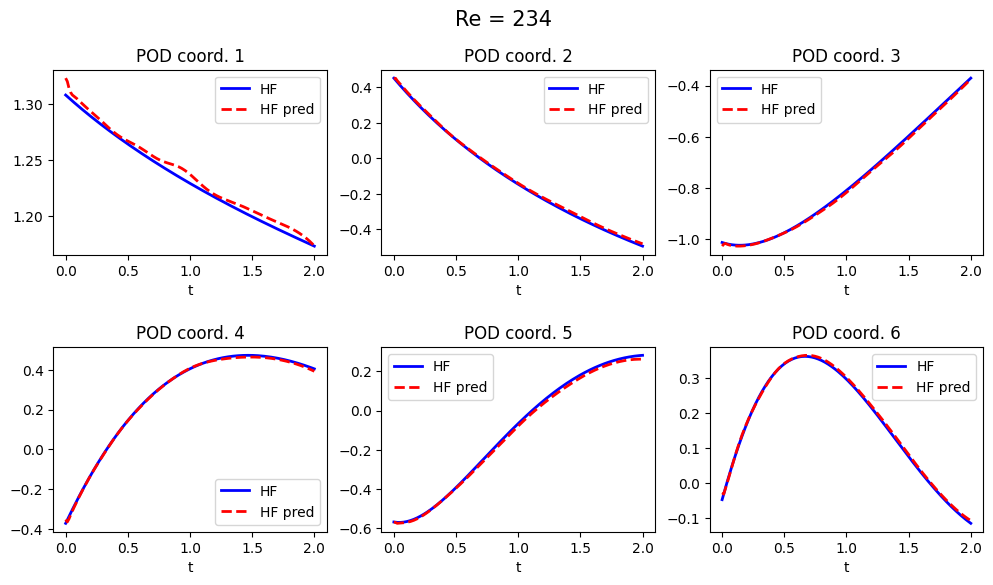

In [ ]:
#########################   PREDICTION    ##########################

# Predictions on test data
output_pred = model.predict(input_test)

# Plot predicted POD coordinates
ind_test = [0] # Re = 235
for ind_re in ind_test:
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize=15)
    for mode in range(6):
      plt.subplot(231 + mode)
      plt.plot(t, output_test[ind_re,:,mode],'b-', label = 'HF', linewidth = 2)
      plt.plot(t, output_pred[ind_re, :, mode], 'r--', label = 'HF pred', linewidth = 2)
      plt.xlabel('t')
      plt.title('POD coord. ' + str(mode+1))
      plt.legend()
    plt.show()

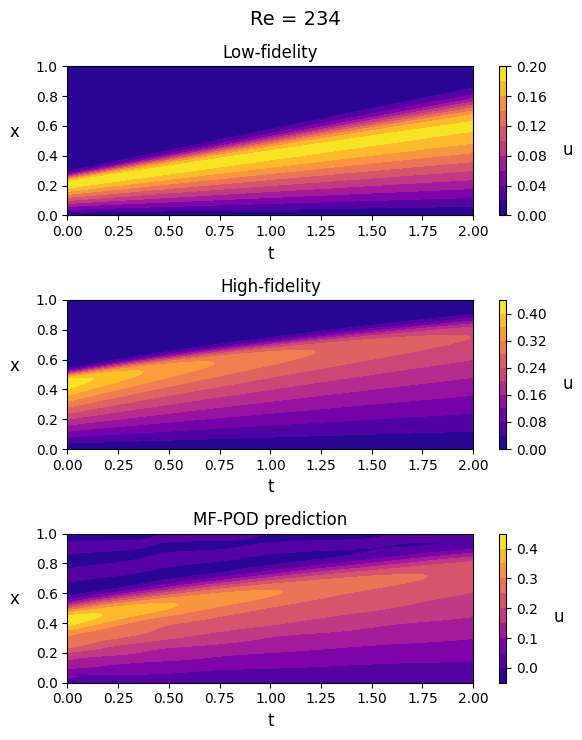

In [ ]:
#Reconstruct solution

u_pred = output_pred @ basis.T

#Compare with HF solution
for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 7.5))
  plt.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize = 14)
  ax = fig.add_subplot(311)
  surf = ax.contourf(t_grid, x_grid, u_lf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Low-fidelity', fontsize=12)
  ax = fig.add_subplot(312)
  surf = ax.contourf(t_grid, x_grid, u_hf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('High-fidelity', fontsize=12)
  ax = fig.add_subplot(313)
  surf = ax.contourf(t_grid, x_grid, u_pred[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('MF-POD prediction', fontsize=12)
  plt.tight_layout()
  plt.show()

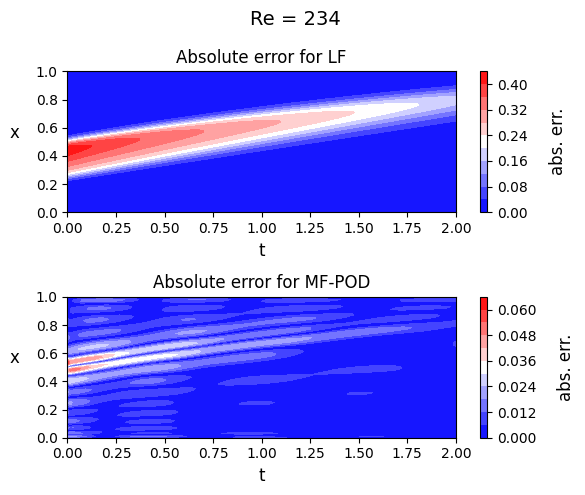

In [ ]:
#Compute and plot errors
rel_err_lf = np.linalg.norm(u_lf_test - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])
rel_err_pred = np.linalg.norm(u_pred - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])

abs_err_lf = np.abs(u_lf_test - u_hf_test)
abs_err_pred = np.abs(u_pred - u_hf_test)

for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 5))
  plt.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize = 14)
  ax = fig.add_subplot(211)
  surf = ax.contourf(t_grid, x_grid, abs_err_lf[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for LF', fontsize=12)
  ax = fig.add_subplot(212)
  surf = ax.contourf(t_grid, x_grid, abs_err_pred[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for MF-POD', fontsize=12)
  plt.tight_layout()
  plt.show()


### **References**
</br>

[1] **Conti P, Guo M, Manzoni A, Brunton S L, Kutz J N**. [Multi-fidelity reduced-order modeling](https://arxiv.org/abs/2309.00325), *preprint arXiv:2308.01602* (2023).

[2] **Conti P, Mengwu G, Manzoni A, Hesthaven J S**.  [Multi-fidelity surrogate modeling using long short-term memory networks](https://www.sciencedirect.com/science/article/abs/pii/S0045782522007678?via%3Dihub), *CMAME* (2023).

[3] **Mengwu G, Manzoni A, Amendt M, Conti P, Hesthaven J S**.  [Multi-fidelity regression using artificial neural networks: Efficient approximation of parameter-dependent output quantities](https://www.sciencedirect.com/science/article/pii/S0045782521006411?via%3Dihub), *CMAME* (2022).


#### **Extra**
You can find the code for a reaction-diffusion problem at the [Multi-fidelity POD repository](https://github.com/ContiPaolo/MultiFidelity_POD)

⭐ Leave a star to the github repo if you enojyed :)